In [ ]:
# ======================
# Import library
# ======================
import tensorflow as tf
from tensorflow.keras import layers, models
import os, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.utils import class_weight
import seaborn as sns

In [16]:
# ======================
# Konfigurasi
# ======================
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 30

DATASET_DIR = "dataset_classification"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [17]:
# ======================
# Load dataset
# ======================
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Kelas yang terdeteksi: {class_names}")

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print("✅ Dataset siap untuk training")


Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Kelas yang terdeteksi: ['Ganoderma', 'Sehat']
✅ Dataset siap untuk training


In [18]:
# ======================
# Hitung class weights untuk menangani imbalance
# ======================
y_train = []
for _, labels in train_ds:
    y_train.extend(np.argmax(labels.numpy(), axis=1))
y_train = np.array(y_train)

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8225), 1: np.float64(1.2751937984496124)}


In [19]:
# ======================
# Definisi model CNN + Softmax
# ======================
def build_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,234 (21.48 MB)

 Trainable params: 5,631,234 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# ======================
# Training
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)

# Simpan model
# model.save("model_cnn_no_augmentation.h5")
print("✅ Training selesai, model tersimpan")

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4473 - loss: 365.9216 - val_accuracy: 0.6058 - val_loss: 0.8657
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5267 - loss: 2.2161 - val_accuracy: 0.3942 - val_loss: 3.3874
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5227 - loss: 1.9271 - val_accuracy: 0.4135 - val_loss: 0.7176
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4845 - loss: 0.7357 - val_accuracy: 0.4808 - val_loss: 0.7057
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6103 - loss: 0.6476 - val_accuracy: 0.5769 - val_loss: 0.6967
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8099 - loss: 0.4881 - val_accuracy: 0.3654 - val_loss: 0.9506
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8544 - loss: 0.3612 - val_accuracy: 0.5000 - val_loss: 0.8471
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9161 - loss: 0.2533 - val_accuracy: 0.5288 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step

=== Evaluation Metrics ===
Accuracy  : 0.4762
Precision : 0.4244
Recall    : 0.4762
F1-Score  : 0.4428
Loss      : 3.6432
Rata-rata waktu inferensi per gambar: 0.0872 detik


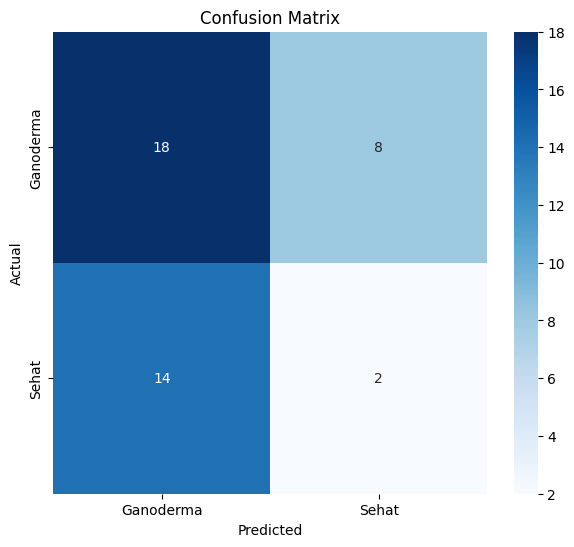

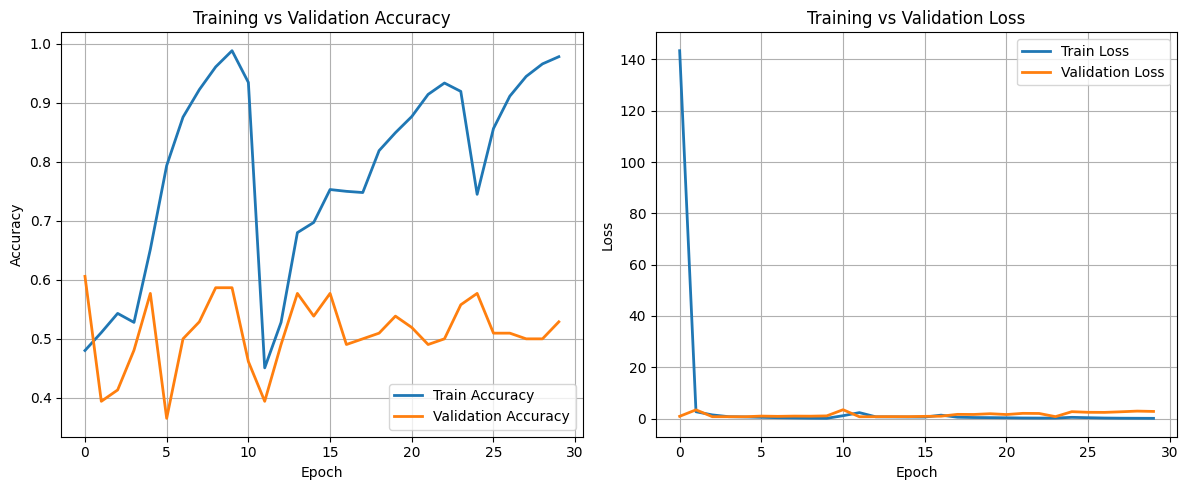

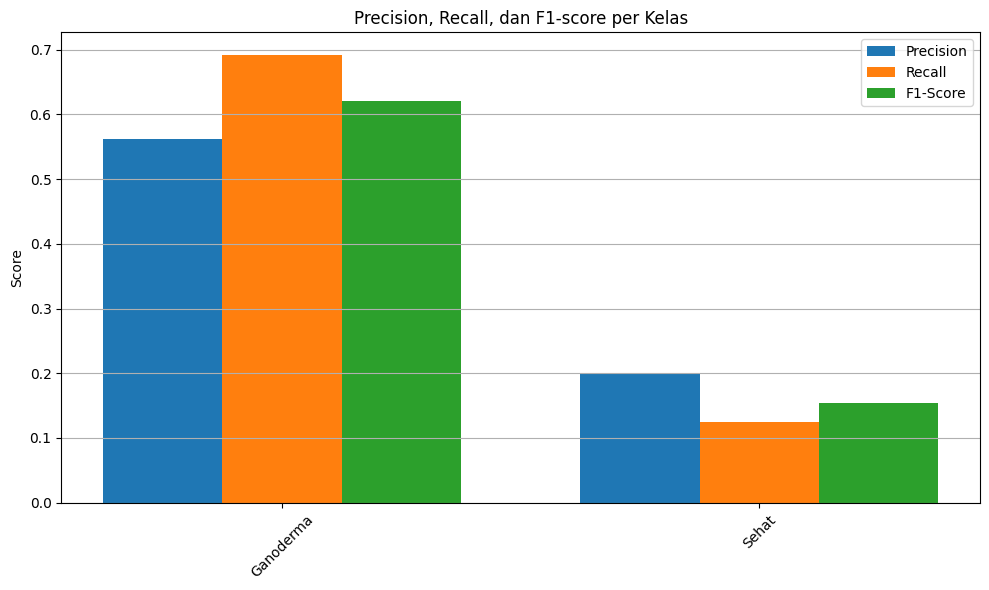

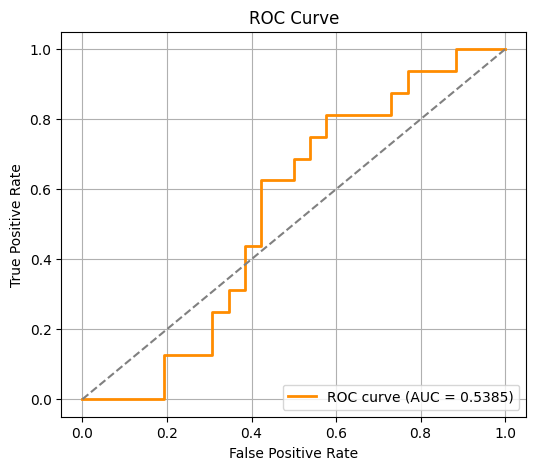

C:\Users\wangp\AppData\Local\Temp\ipykernel_7908\3397364056.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


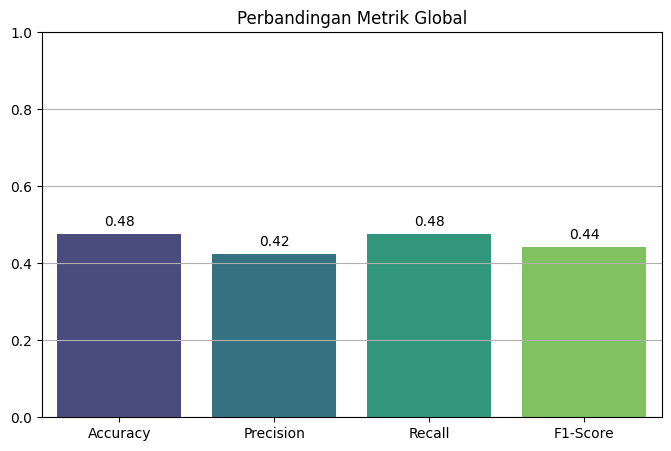

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


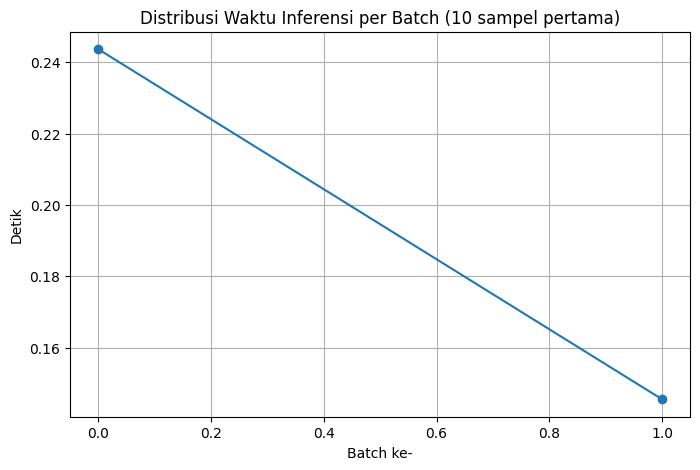


=== Classification Report ===
              precision    recall  f1-score   support

   Ganoderma       0.56      0.69      0.62        26
       Sehat       0.20      0.12      0.15        16

    accuracy                           0.48        42
   macro avg       0.38      0.41      0.39        42
weighted avg       0.42      0.48      0.44        42



In [22]:
# ======================
# Evaluasi model dan visualisasi
# ======================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

y_true, y_pred, y_prob = [], [], []

start_time = time.time()
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_prob.extend(preds)
end_time = time.time()

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
inference_time = (end_time - start_time) / len(y_true)

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Loss      : {test_loss:.4f}")
print(f"Rata-rata waktu inferensi per gambar: {inference_time:.4f} detik")

# ======================
# 1️⃣ Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================
# 2️⃣ Grafik Training History (Accuracy & Loss)
# ======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ======================
# 3️⃣ Grafik Precision, Recall, F1-score per Kelas
# ======================
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
precisions = [report[c]['precision'] for c in class_names]
recalls = [report[c]['recall'] for c in class_names]
f1s = [report[c]['f1-score'] for c in class_names]

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-Score')
plt.xticks(x, class_names, rotation=45)
plt.ylabel("Score")
plt.title("Precision, Recall, dan F1-score per Kelas")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ======================
# 4️⃣ ROC Curve (macro-average)
# ======================
if NUM_CLASSES > 2:
    y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= NUM_CLASSES

    plt.figure(figsize=(7,6))
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f'Macro-average ROC (AUC = {np.mean(list(roc_auc.values())):.4f})')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-average ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    fpr, tpr, _ = roc_curve(y_true, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# ======================
# 5️⃣ Perbandingan Global Metrics
# ======================
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [acc, prec, rec, f1]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.title("Perbandingan Metrik Global")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.grid(True, axis='y')
plt.show()

# ======================
# 6️⃣ Distribusi waktu inferensi (perkiraan)
# ======================
batch_times = []
for images, labels in test_ds.take(10):
    start = time.time()
    _ = model.predict(images)
    end = time.time()
    batch_times.append(end - start)

plt.figure(figsize=(8,5))
plt.plot(batch_times, marker='o')
plt.title("Distribusi Waktu Inferensi per Batch (10 sampel pertama)")
plt.xlabel("Batch ke-")
plt.ylabel("Detik")
plt.grid(True)
plt.show()

# ======================
# 7️⃣ Cetak Classification Report Lengkap
# ======================
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
